In [1]:
import os
import random
import shutil
from glob import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

Helper functions

In [2]:
def get_img(img):
    # For image loading
    # Read img file; Convert BGR -> RGB; Standardise
    img = cv2.imread(img)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255

def show_img(img):
    # For image visualisation
    # Load to cpu, detach gradient, cast to ndarray and unstandardise
    img = img.to('cpu').detach().numpy() * 255
    img = img.astype(np.uint8)
    img = np.transpose(img, (1, 2, 0))

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(img)

def seed_everything(seed):
    # For reproducibility
    # https://pytorch.org/docs/stable/notes/randomness.html
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # torch.backends.cudnn.benchmark = False
    # torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)

def seed_worker(worker_id):
    # Used to preserve reproducibility in DataLoader
    # https://pytorch.org/docs/stable/notes/randomness.html
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


In [3]:
def train_test_split(fungi_list, 
                     fungi_root='../data/defungi/',
                     train_end=0.65,
                     val_end=0.80):
    for i, c in enumerate(['H1', 'H2', 'H3', 'H5', 'H6']):
        fungi = np.array(fungi_list[i])

        n = len(fungi)
        indices = np.arange(n)
        train_idx = int(n * train_end)
        val_idx = int(n * val_end)

        np.random.shuffle(indices)
        train_indices = indices[:train_idx]
        val_indices = indices[train_idx:val_idx]
        trainval_indices = indices[:val_idx]
        test_indices = indices[val_idx:]

        train = fungi[train_indices]
        val = fungi[val_indices]
        trainval = fungi[trainval_indices]
        test = fungi[test_indices]

        # This shows that there is no intersection between train and test set
        print(np.intersect1d(train, val),
              np.intersect1d(trainval, test))

        for subset, path in zip([train, val, trainval, test],
                                ['train', 'val', 'trainval', 'test']):
            dst = f'{fungi_root}{path}/{c}/'
            os.makedirs(dst, exist_ok=True)
            for src in subset:
                shutil.copy(src, dst)    
    
        # dst = f'{fungi_root}val/{c}/'
        # os.makedirs(dst, exist_ok=True)
        # for src in val:    
        #     shutil.copy(src, dst)

        # dst = f'{fungi_root}test/{c}/'
        # os.makedirs(dst, exist_ok=True)
        # for src in test:    
        #     shutil.copy(src, dst)

def get_fungi_list(fungi_root):
    return [
        glob(f'{fungi_root}{h}/*') for h in [
            'H1', 'H2', 'H3', 'H5', 'H6'
        ]
    ]


In [4]:
class FungiDataset(Dataset):
    def __init__(self, fungi_root, transform=None, target_transform=None):
        fungi_list = get_fungi_list(fungi_root)
        self.transform = transform
        self.target_transform = target_transform

        # TRAIN VAL TRAINVAL TEST........

        # n = 700
        # RANDOM SAMPLE
        # n = min
        # ALBUMENTATIONS

        # TODO: random sample with seed
        print('\n'.join([f'Class {i}: {len(fungi_list[i])} samples' 
                             for i in range(len(fungi_list))]))
        # fungi_list = [h[:n] for h in fungi_list]
        # print('\n'.join([f'Class {i}: {len(fungi_list[i])} samples' 
        #                 for i in range(len(fungi_list))]))
        self.fungi = np.concatenate([
            np.array(h) for h in fungi_list
        ])

        # Create labels for the 5 fungi classes
        indices = [len(h) for h in fungi_list]
        self.labels = np.zeros(sum(indices))
        c1 = sum(indices[:1])
        c2 = sum(indices[:2])
        c3 = sum(indices[:3])
        c4 = sum(indices[:4])
        self.labels[c1:c2] = 1
        self.labels[c2:c3] = 2
        self.labels[c3:c4] = 3
        self.labels[c4:] = 4

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # make copies to match max size
        # always use albumentations (is this ok btw)
        img = get_img(self.fungi[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)

        return img, label

In [106]:
class AugmentedFungiDataset(Dataset):
    def __init__(self, fungi_root, transform=None, target_transform=None):
        fungi_list = get_fungi_list(fungi_root)
        self.transform = transform
        self.target_transform = target_transform

        fungi = [np.array(h) for h in fungi_list]
        nfungi = [len(h) for h in fungi]
        max_nfungi = max(nfungi)
        shortage = max_nfungi - np.array(nfungi)

        augmented_fungi = []
        for idx in range(5):
            copies = np.random.choice(fungi[idx], 
                                      size=shortage[idx], 
                                      replace=True)
            augmented = np.concatenate([fungi[idx], copies])
            augmented_fungi.append(augmented)
        
        self.fungi = np.concatenate(augmented_fungi)
        self.labels = np.concatenate([
            np.zeros(max_nfungi),
            np.ones(max_nfungi),
            np.ones(max_nfungi) * 2,
            np.ones(max_nfungi) * 3,
            np.ones(max_nfungi) * 4,
        ])

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # make copies to match max size
        # always use albumentations (is this ok btw)
        img = get_img(self.fungi[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)

        return img, label


In [28]:
fungi_list = get_fungi_list(FUNGI_ROOT)
fungi = [np.array(h) for h in fungi_list]


In [78]:
nfungi = [len(h) for h in fungi]
shortage = max(nfungi) - np.array(nfungi)

augmented_fungi = []
for idx in range(5):
    copies = np.random.choice(fungi[idx], 
                              size=shortage[idx], 
                              replace=True)
    augmented = np.concatenate([fungi[idx], copies])
    augmented_fungi.append(augmented)


array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [98]:
max(nfungi) - len(np.unique(augmented_fungi[4]))

3665

In [65]:
nfungi

[4404, 2334, 819, 818, 739]

In [61]:
shortage

array([   0, 2070, 3585, 3586, 3665])

In [42]:
np.concatenate([
    np.random.choice(fungi[0], size=10, replace=True),
    np.random.choice(fungi[0], size=10, replace=True)
])

array(['../data/defungi/H1/H1_114a_6.jpg',
       '../data/defungi/H1/H1_5c_6.jpg',
       '../data/defungi/H1/H1_30b_2.jpg',
       '../data/defungi/H1/H1_63d_12.jpg',
       '../data/defungi/H1/H1_88a_5.jpg',
       '../data/defungi/H1/H1_1d_11.jpg',
       '../data/defungi/H1/H1_65b_6.jpg',
       '../data/defungi/H1/H1_95b_13.jpg',
       '../data/defungi/H1/H1_1d_7.jpg',
       '../data/defungi/H1/H1_67a_6.jpg',
       '../data/defungi/H1/H1_40b_4.jpg',
       '../data/defungi/H1/H1_22a_5.jpg',
       '../data/defungi/H1/H1_36a_5.jpg',
       '../data/defungi/H1/H1_67c_13.jpg',
       '../data/defungi/H1/H1_57c_6.jpg',
       '../data/defungi/H1/H1_94a_9.jpg',
       '../data/defungi/H1/H1_99a_2.jpg',
       '../data/defungi/H1/H1_48d_8.jpg',
       '../data/defungi/H1/H1_70a_8.jpg',
       '../data/defungi/H1/H1_74c_16.jpg'], dtype='<U33')

In [101]:
augmented_fungi

[array(['../data/defungi/H1/H1_76b_11.jpg',
        '../data/defungi/H1/H1_57c_1.jpg',
        '../data/defungi/H1/H1_91a_17.jpg', ...,
        '../data/defungi/H1/H1_6b_7.jpg',
        '../data/defungi/H1/H1_105e_9.jpg',
        '../data/defungi/H1/H1_48c_5.jpg'], dtype='<U33'),
 array(['../data/defungi/H2/H2_40a_4.jpg',
        '../data/defungi/H2/H2_60a_22.jpg',
        '../data/defungi/H2/H2_33a_13.jpg', ...,
        '../data/defungi/H2/H2_23d_20.jpg',
        '../data/defungi/H2/H2_75a_9.jpg',
        '../data/defungi/H2/H2_8f_15.jpg'], dtype='<U32'),
 array(['../data/defungi/H3/H3_4a_3.jpg',
        '../data/defungi/H3/H3_11a_38.jpg',
        '../data/defungi/H3/H3_5a_47.jpg', ...,
        '../data/defungi/H3/H3_4a_17.jpg',
        '../data/defungi/H3/H3_11a_38.jpg',
        '../data/defungi/H3/H3_4b_20.jpg'], dtype='<U32'),
 array(['../data/defungi/H5/H5_1b_1.jpg',
        '../data/defungi/H5/H5_91a_2.jpg',
        '../data/defungi/H5/H5_112b_1.jpg', ...,
        '../data/defung

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = self.conv(in_channels=3, out_channels=8)
        self.conv2 = self.conv(in_channels=8, out_channels=16)
        self.conv3 = self.conv(in_channels=16, out_channels=32)
        self.conv4 = self.conv(in_channels=32, out_channels=64)
        self.conv5 = self.conv(in_channels=64, out_channels=128)
        self.conv6 = self.conv(in_channels=128, out_channels=128)
        self.conv7 = self.conv(in_channels=128, out_channels=128)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(3**2 * 128, 512)
        self.fc2 = nn.Linear(512, 5)
    
    def conv(self, in_channels, out_channels):
        return nn.Conv2d(in_channels=in_channels,
                                     out_channels= out_channels,
                                     kernel_size=3, 
                                     padding='same')
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.pool(F.relu(self.conv7(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        

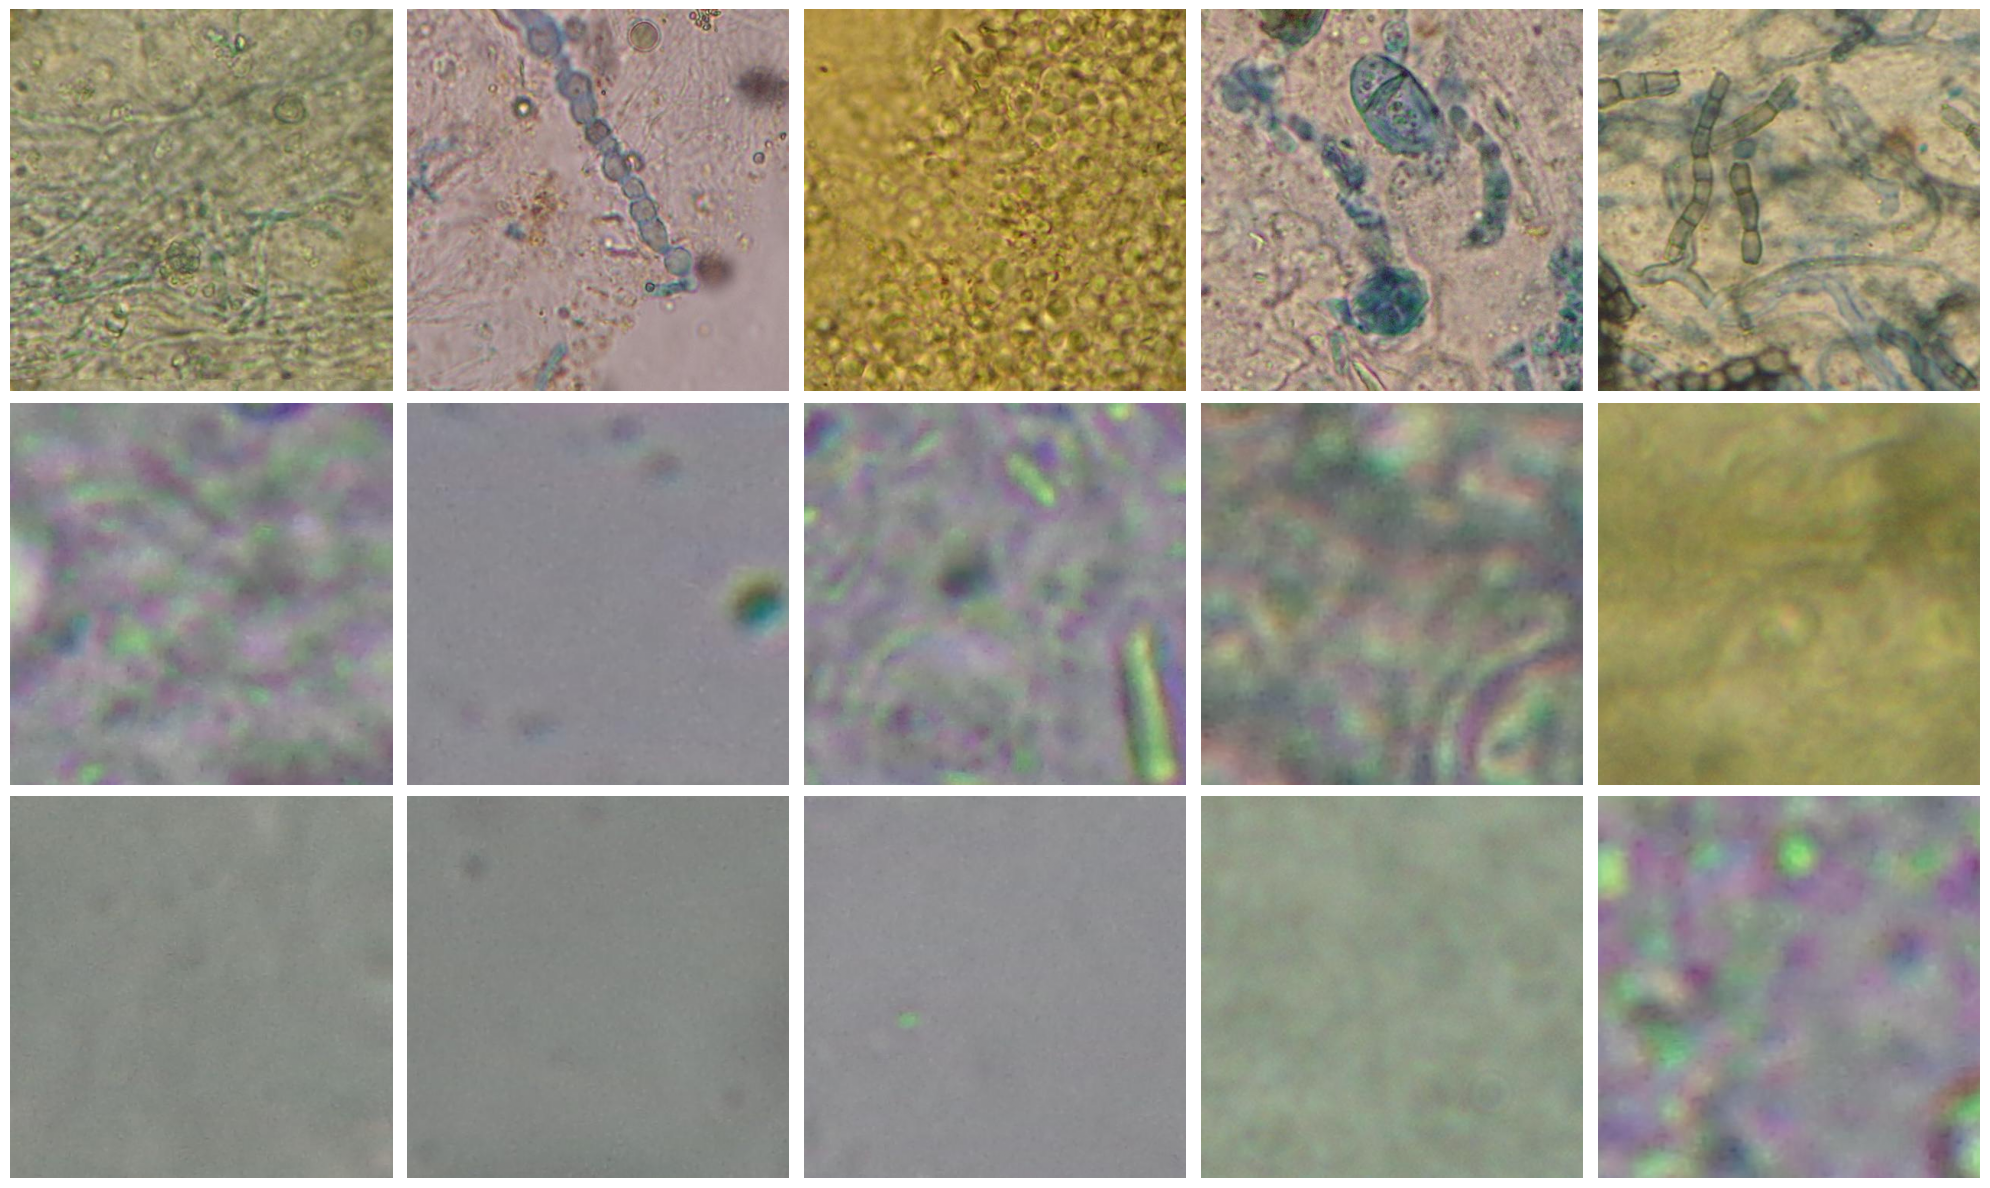

In [6]:
h1_good = get_img('../data/defungi/trainval/H1/H1_224a_1.jpg')
h1_ok = get_img('../data/defungi/trainval/H1/H1_7c_7.jpg')
h1_bad = get_img('../data/defungi/trainval/H1/H1_111a_13.jpg')

h2_good = get_img('../data/defungi/trainval/H2/H2_108a_1.jpg')
h2_ok = get_img('../data/defungi/trainval/H2/H2_13a_8.jpg')
h2_bad = get_img('../data/defungi/trainval/H2/H2_12a_7.jpg')

h3_good = get_img('../data/defungi/trainval/H3/H3_15a_2.jpg')
h3_ok = get_img('../data/defungi/trainval/H3/H3_1a_25.jpg')
h3_bad = get_img('../data/defungi/trainval/H3/H3_1a_31.jpg')

h5_good = get_img('../data/defungi/trainval/H5/H5_14a_3.jpg')
h5_ok = get_img('../data/defungi/trainval/H5/H5_15a_1.jpg')
h5_bad = get_img('../data/defungi/trainval/H5/H5_105a_5.jpg')

h6_good = get_img('../data/defungi/trainval/H6/H6_24a_2.jpg')
h6_ok = get_img('../data/defungi/trainval/H6/H6_70a_5.jpg')
h6_bad = get_img('../data/defungi/trainval/H6/H6_2a_5.jpg')

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))
images = [[h1_good, h2_good, h3_good, h5_good, h6_good],
          [h1_ok, h2_ok, h3_ok, h5_ok, h6_ok],
          [h1_bad, h2_bad, h3_bad, h5_bad, h6_bad]]

for i in range(3):
    for j in range(5):
        axes[i][j].axis('off')
        axes[i][j].imshow(images[i][j])

plt.tight_layout()
plt.show()

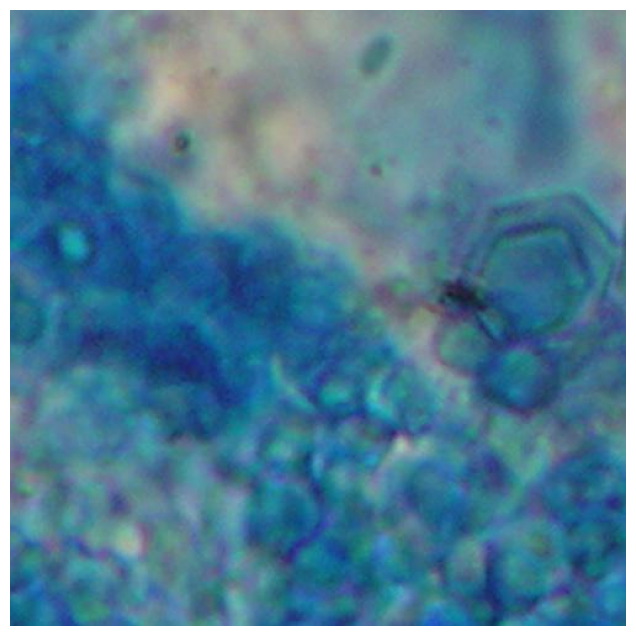

In [7]:
img = get_img('../data/defungi/trainval/H3/H3_36a_3.jpg')
img = get_img('../data/defungi/trainval/H3/H3_20a_1.jpg')

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(img)
plt.show()

In [8]:
# RANDOM (WITH SEED) SAMPLING
# SEED EVERYTHING
# +sort glob

# deep model, ..., not enough data? -> augment albumentations
# first loss???

# train val test
# train loss val loss

In [9]:
SEED = 42
FUNGI_ROOT = '../data/defungi/'

seed_everything(SEED)

In [10]:
# Splits data into train and test subsets
# Copies files into train/ & test/ subdirectories
train_test_split(get_fungi_list(FUNGI_ROOT), 
                 fungi_root=FUNGI_ROOT, 
                 train_end=0.65,
                 val_end=0.80)

[] []
[] []
[] []
[] []
[] []


In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [12]:
print('--TRAIN')
train_dataset = FungiDataset(fungi_root=f'{FUNGI_ROOT}train/', transform=transform)
print('--VAL')
val_dataset = FungiDataset(fungi_root=f'{FUNGI_ROOT}val/', transform=transform)
print('--TRAINVAL')
trainval_dataset = FungiDataset(fungi_root=f'{FUNGI_ROOT}trainval/', transform=transform)
print('--TEST')
test_dataset = FungiDataset(fungi_root=f'{FUNGI_ROOT}test/', transform=transform)

batch_size = 4
num_workers = 12

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=torch.Generator().manual_seed(SEED),
)
print(f'TRAIN: Dataset size: {len(train_dataset)}')
print(f'TRAIN: Number of iterations per epoch: {len(train_dataloader)}')
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    worker_init_fn=seed_worker,
    generator=torch.Generator().manual_seed(SEED),
)
print(f'VAL: Dataset size: {len(val_dataset)}')
print(f'VAL: Number of iterations per epoch: {len(val_dataloader)}')
trainval_dataloader = DataLoader(
    trainval_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=torch.Generator().manual_seed(SEED),
)
print(f'TRAINVAL: Dataset size: {len(trainval_dataset)}')
print(f'TRAINVAL: Number of iterations per epoch: {len(trainval_dataloader)}')
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    worker_init_fn=seed_worker,
    generator=torch.Generator().manual_seed(SEED),
)
print(f'TEST: Dataset size: {len(test_dataset)}')
print(f'TEST: Number of iterations per epoch: {len(test_dataloader)}')


--TRAIN
Class 0: 2862 samples
Class 1: 1517 samples
Class 2: 532 samples
Class 3: 531 samples
Class 4: 480 samples
--VAL
Class 0: 661 samples
Class 1: 350 samples
Class 2: 123 samples
Class 3: 123 samples
Class 4: 111 samples
--TRAINVAL
Class 0: 3523 samples
Class 1: 1867 samples
Class 2: 655 samples
Class 3: 654 samples
Class 4: 591 samples
--TEST
Class 0: 881 samples
Class 1: 467 samples
Class 2: 164 samples
Class 3: 164 samples
Class 4: 148 samples
TRAIN: Dataset size: 5922
TRAIN: Number of iterations per epoch: 1481
VAL: Dataset size: 1368
VAL: Number of iterations per epoch: 342
TRAINVAL: Dataset size: 7290
TRAINVAL: Number of iterations per epoch: 1823
TEST: Dataset size: 1824
TEST: Number of iterations per epoch: 456


Feature batch shape: torch.Size([4, 3, 500, 500])
Labels batch shape: torch.Size([4])


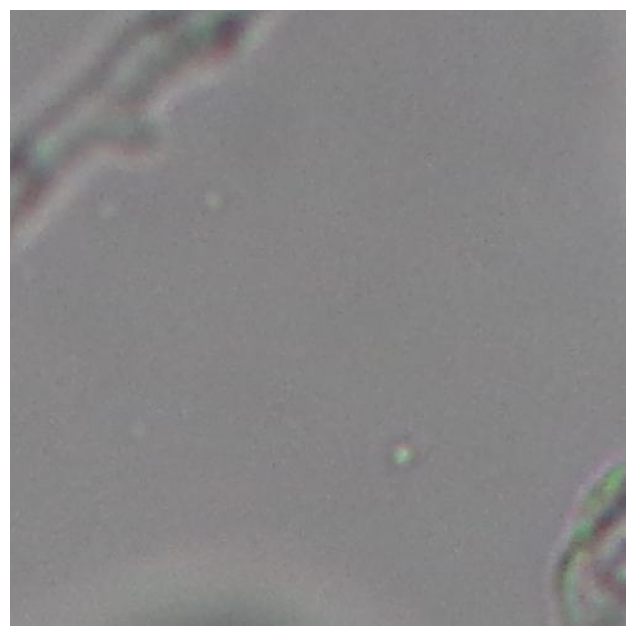

In [13]:
# idx = 0
idx = 3
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[idx].squeeze()
label = train_labels[idx]

show_img(img)


Feature batch shape: torch.Size([4, 3, 500, 500])
Labels batch shape: torch.Size([4])
Feature shape: torch.Size([3, 500, 500])
Labels shape: torch.Size([])


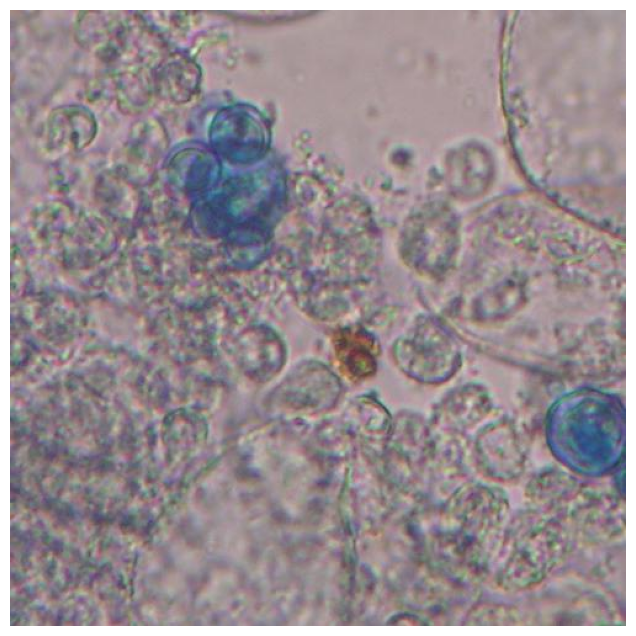

In [10]:
idx = 3
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[idx].squeeze()
label = train_labels[idx]
print(f"Feature shape: {img.size()}")
print(f"Labels shape: {label.size()}")

show_img(img)

In [14]:
cnn = ConvNet().to('cuda')

In [15]:
print(cnn)

ConvNet(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)


In [16]:
[param.nelement() for param in cnn.parameters()]

[216,
 8,
 1152,
 16,
 4608,
 32,
 18432,
 64,
 73728,
 128,
 147456,
 128,
 147456,
 128,
 589824,
 512,
 2560,
 5]

In [17]:
sum([param.nelement() for param in cnn.parameters()])

986453

In [18]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn.parameters(), 
                                                lr=0.0001, 
                                                weight_decay=0,
                                                amsgrad=False)
# optimizer = torch.optim.AdamW(cnn.parameters(), 
#                                                     lr=0.001, 
#                                                     weight_decay=0.01, 
#                                                     amsgrad=False)

In [19]:
# links: data
# linke: pytorhc.org????
# references

# device if cuda availabe

In [20]:
EPOCHS = 2

In [22]:
for epoch in range(EPOCHS):
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_dataloader, 0):
        images = images.to('cuda', dtype=torch.float)
        labels = labels.to('cuda', dtype=torch.int64)

        optimizer.zero_grad()

        predictions = cnn(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # print every 100 mini-batches
        if not(i % 100) and i:
            print(f'EPOCH {epoch}: LOSS={running_loss/i}')


# EPOCH 0: LOSS=1.627578890323639
# EPOCH 0: LOSS=1.6194562083482742
# EPOCH 0: LOSS=1.6163852659861246
# EPOCH 0: LOSS=1.6142957371473312
# EPOCH 0: LOSS=1.6031000547409058
# EPOCH 0: LOSS=1.576366246143977
# EPOCH 0: LOSS=1.5409805292742593
# EPOCH 0: LOSS=1.5158645297586917
# EPOCH 1: LOSS=1.330617059469223
# EPOCH 1: LOSS=1.3007452088594436
# EPOCH 1: LOSS=1.306802797317505
# EPOCH 1: LOSS=1.3036507059633733
# EPOCH 1: LOSS=1.2990412013530732
# EPOCH 1: LOSS=1.2901422305901846
# EPOCH 1: LOSS=1.274499237707683
# EPOCH 1: LOSS=1.2583802120387555

EPOCH 0: LOSS=1.4365745723247527
EPOCH 0: LOSS=1.4012092968821526
EPOCH 0: LOSS=1.4009921673933665
EPOCH 0: LOSS=1.390145034790039
EPOCH 0: LOSS=1.3663433132171632
EPOCH 0: LOSS=1.331524601628383
EPOCH 0: LOSS=1.285626061303275
EPOCH 0: LOSS=1.256549818702042
EPOCH 0: LOSS=1.2325172504948245
EPOCH 0: LOSS=1.2099692273885012
EPOCH 0: LOSS=1.1957572973045436
EPOCH 0: LOSS=1.1835947374999523
EPOCH 0: LOSS=1.1705836302729753
EPOCH 0: LOSS=1.1608074280193874
EPOCH 1: LOSS=1.081797898709774
EPOCH 1: LOSS=1.0672891783714293
EPOCH 1: LOSS=1.042226367741823
EPOCH 1: LOSS=1.0519236486777663
EPOCH 1: LOSS=1.0548178264796735
EPOCH 1: LOSS=1.0437087546040615
EPOCH 1: LOSS=1.0295306042262486
EPOCH 1: LOSS=1.026242179684341
EPOCH 1: LOSS=1.0233135596579976
EPOCH 1: LOSS=1.0284476749897002
EPOCH 1: LOSS=1.023903052982959
EPOCH 1: LOSS=1.025872608659168
EPOCH 1: LOSS=1.0246185245192967
EPOCH 1: LOSS=1.024606465346047


In [23]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in train_dataloader:
        images = images.to('cuda', dtype=torch.float)
        labels = labels.to('cuda', dtype=torch.int64)

        predictions = cnn(images)
        _, predictions = torch.max(predictions.data, 1)
        
        predictions = predictions.to('cpu').detach().numpy()
        labels = labels.to('cpu').detach().numpy()
        
        y_pred.extend(predictions)
        y_true.extend(labels)        

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [24]:
pr = precision_score(y_true, y_pred, average='macro')
re = recall_score(y_true=y_true, y_pred=y_pred, average='macro')

print(f'Precision: {pr}')
print(f'Recall: {re}')

# Precision: 0.4881209460443633
# Recall: 0.5122857142857142

Precision: 0.38666367530238765
Recall: 0.4046699251862094


/home/sibeard/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
np.unique(y_pred)

array([0, 1, 3, 4])

In [26]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

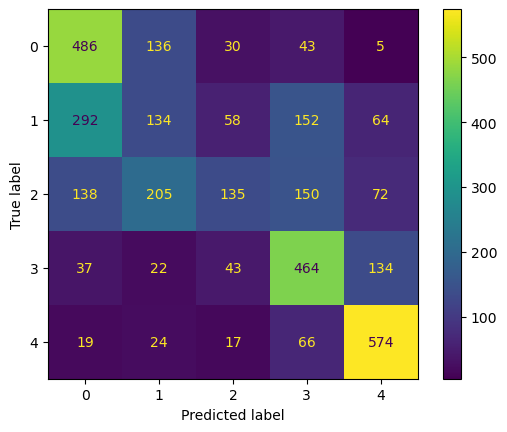

In [23]:
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.show()

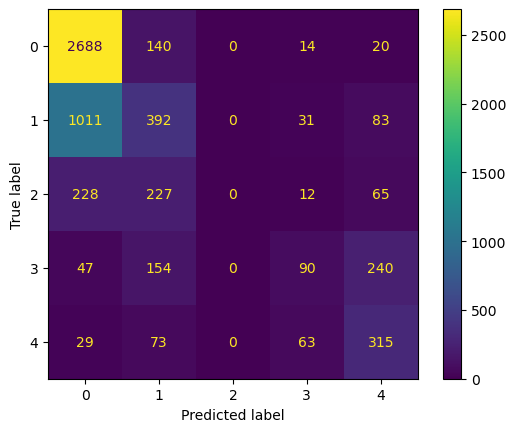

In [27]:
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.show()

In [24]:
crep = classification_report(y_true=y_true, y_pred=y_pred)

In [25]:
print(crep)

              precision    recall  f1-score   support

           0       0.50      0.69      0.58       700
           1       0.26      0.19      0.22       700
           2       0.48      0.19      0.27       700
           3       0.53      0.66      0.59       700
           4       0.68      0.82      0.74       700

    accuracy                           0.51      3500
   macro avg       0.49      0.51      0.48      3500
weighted avg       0.49      0.51      0.48      3500



In [113]:
print('--TRAIN')
train_dataset = AugmentedFungiDataset(fungi_root=f'{FUNGI_ROOT}train/', transform=transform)
print('--VAL')
val_dataset = AugmentedFungiDataset(fungi_root=f'{FUNGI_ROOT}val/', transform=transform)

batch_size = 4
num_workers = 12

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=torch.Generator().manual_seed(SEED),
)
print(f'TRAIN: Dataset size: {len(train_dataset)}')
print(f'TRAIN: Number of iterations per epoch: {len(train_dataloader)}')
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    worker_init_fn=seed_worker,
    generator=torch.Generator().manual_seed(SEED),
)
print(f'VAL: Dataset size: {len(val_dataset)}')
print(f'VAL: Number of iterations per epoch: {len(val_dataloader)}')
trainval_dataloader = DataLoader(
    trainval_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=torch.Generator().manual_seed(SEED),
)


--TRAIN
--VAL
TRAIN: Dataset size: 14310
TRAIN: Number of iterations per epoch: 3578
VAL: Dataset size: 3305
VAL: Number of iterations per epoch: 827


In [111]:
int(4404*0.65) * 5

14310

In [112]:
int(4404*0.15) * 5

3300

In [115]:
cnn = ConvNet().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), 
                             lr=0.0001, 
                             weight_decay=0,
                             amsgrad=False)

In [116]:
EPOCHS = 2 #(!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1)

In [117]:
for epoch in range(EPOCHS):
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_dataloader, 0):
        images = images.to('cuda', dtype=torch.float)
        labels = labels.to('cuda', dtype=torch.int64)

        optimizer.zero_grad()

        predictions = cnn(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # print every 100 mini-batches
        if not(i % 100) and i:
            print(f'EPOCH {epoch}: LOSS={running_loss/i}')


# EPOCH 0: LOSS=1.627578890323639
# EPOCH 0: LOSS=1.6194562083482742
# EPOCH 0: LOSS=1.6163852659861246
# EPOCH 0: LOSS=1.6142957371473312
# EPOCH 0: LOSS=1.6031000547409058
# EPOCH 0: LOSS=1.576366246143977
# EPOCH 0: LOSS=1.5409805292742593
# EPOCH 0: LOSS=1.5158645297586917
# EPOCH 1: LOSS=1.330617059469223
# EPOCH 1: LOSS=1.3007452088594436
# EPOCH 1: LOSS=1.306802797317505
# EPOCH 1: LOSS=1.3036507059633733
# EPOCH 1: LOSS=1.2990412013530732
# EPOCH 1: LOSS=1.2901422305901846
# EPOCH 1: LOSS=1.274499237707683
# EPOCH 1: LOSS=1.2583802120387555

# EPOCH 0: LOSS=1.4365745723247527
# EPOCH 0: LOSS=1.4012092968821526
# EPOCH 0: LOSS=1.4009921673933665
# EPOCH 0: LOSS=1.390145034790039
# EPOCH 0: LOSS=1.3663433132171632
# EPOCH 0: LOSS=1.331524601628383
# EPOCH 0: LOSS=1.285626061303275
# EPOCH 0: LOSS=1.256549818702042
# EPOCH 0: LOSS=1.2325172504948245
# EPOCH 0: LOSS=1.2099692273885012
# EPOCH 0: LOSS=1.1957572973045436
# EPOCH 0: LOSS=1.1835947374999523
# EPOCH 0: LOSS=1.1705836302729753
# EPOCH 0: LOSS=1.1608074280193874
# EPOCH 1: LOSS=1.081797898709774
# EPOCH 1: LOSS=1.0672891783714293
# EPOCH 1: LOSS=1.042226367741823
# EPOCH 1: LOSS=1.0519236486777663
# EPOCH 1: LOSS=1.0548178264796735
# EPOCH 1: LOSS=1.0437087546040615
# EPOCH 1: LOSS=1.0295306042262486
# EPOCH 1: LOSS=1.026242179684341
# EPOCH 1: LOSS=1.0233135596579976
# EPOCH 1: LOSS=1.0284476749897002
# EPOCH 1: LOSS=1.023903052982959
# EPOCH 1: LOSS=1.025872608659168
# EPOCH 1: LOSS=1.0246185245192967
# EPOCH 1: LOSS=1.024606465346047

EPOCH 0: LOSS=1.6258488821983337
EPOCH 0: LOSS=1.618237959742546
EPOCH 0: LOSS=1.5811828323205313
EPOCH 0: LOSS=1.5326782515645028
EPOCH 0: LOSS=1.5037325053215027
EPOCH 0: LOSS=1.465344730714957
EPOCH 0: LOSS=1.4412513186250415
EPOCH 0: LOSS=1.4295820718258618
EPOCH 0: LOSS=1.4162878305382198
EPOCH 0: LOSS=1.4012930276989937
EPOCH 0: LOSS=1.3938111264055426
EPOCH 0: LOSS=1.3814855130761863
EPOCH 0: LOSS=1.3736655296958409
EPOCH 0: LOSS=1.359359290365662
EPOCH 0: LOSS=1.3535801348487535
EPOCH 0: LOSS=1.3448985191993414
EPOCH 0: LOSS=1.3380104687108714
EPOCH 0: LOSS=1.3294162925581137
EPOCH 0: LOSS=1.3267598505239737
EPOCH 0: LOSS=1.3197885663807392
EPOCH 0: LOSS=1.3151565107845125
EPOCH 0: LOSS=1.3077429123087363
EPOCH 0: LOSS=1.3034802625749422
EPOCH 0: LOSS=1.2955708254252871
EPOCH 0: LOSS=1.2887444487333297
EPOCH 0: LOSS=1.281342652382759
EPOCH 0: LOSS=1.2746867145542746
EPOCH 0: LOSS=1.2689709797501565
EPOCH 0: LOSS=1.2616335341180194
EPOCH 0: LOSS=1.2541019544055065
EPOCH 0: LOSS=

In [118]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in train_dataloader:
        images = images.to('cuda', dtype=torch.float)
        labels = labels.to('cuda', dtype=torch.int64)

        predictions = cnn(images)
        _, predictions = torch.max(predictions.data, 1)
        
        predictions = predictions.to('cpu').detach().numpy()
        labels = labels.to('cpu').detach().numpy()
        
        y_pred.extend(predictions)
        y_true.extend(labels)        

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [119]:
pr = precision_score(y_true, y_pred, average='macro')
re = recall_score(y_true=y_true, y_pred=y_pred, average='macro')

print(f'Precision: {pr}')
print(f'Recall: {re}')

# Precision: 0.4881209460443633
# Recall: 0.5122857142857142

# Precision: 0.38666367530238765
# Recall: 0.4046699251862094

Precision: 0.6424992991421
Recall: 0.6304682040531098


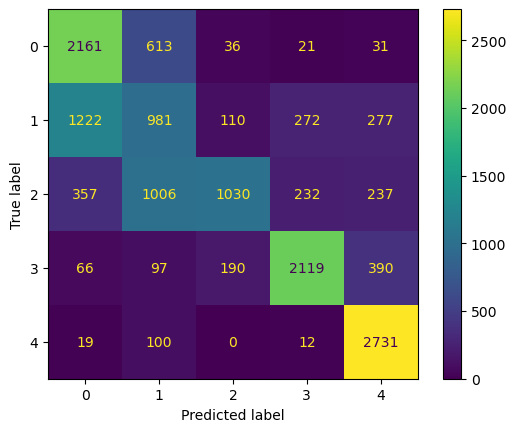

In [121]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.show()

In [122]:
crep = classification_report(y_true=y_true, y_pred=y_pred)
print(crep)

              precision    recall  f1-score   support

           0       0.56      0.76      0.65      2862
           1       0.35      0.34      0.35      2862
           2       0.75      0.36      0.49      2862
           3       0.80      0.74      0.77      2862
           4       0.74      0.95      0.84      2862

    accuracy                           0.63     14310
   macro avg       0.64      0.63      0.62     14310
weighted avg       0.64      0.63      0.62     14310



In [123]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_dataloader:
        images = images.to('cuda', dtype=torch.float)
        labels = labels.to('cuda', dtype=torch.int64)

        predictions = cnn(images)
        _, predictions = torch.max(predictions.data, 1)
        
        predictions = predictions.to('cpu').detach().numpy()
        labels = labels.to('cpu').detach().numpy()
        
        y_pred.extend(predictions)
        y_true.extend(labels)        

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [124]:
pr = precision_score(y_true, y_pred, average='macro')
re = recall_score(y_true=y_true, y_pred=y_pred, average='macro')

print(f'Precision: {pr}')
print(f'Recall: {re}')

# Precision: 0.4881209460443633
# Recall: 0.5122857142857142

# Precision: 0.38666367530238765
# Recall: 0.4046699251862094

Precision: 0.6121155236738982
Recall: 0.6084720121028744


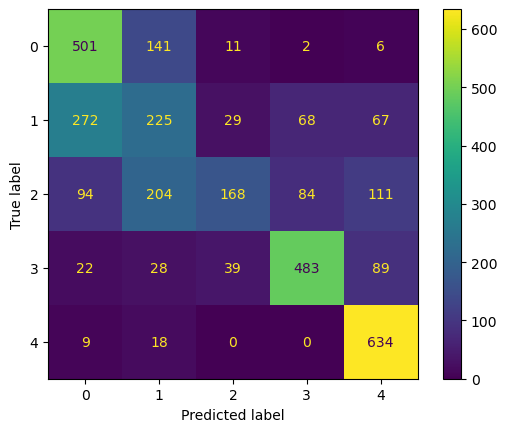

In [125]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.show()

In [126]:
crep = classification_report(y_true=y_true, y_pred=y_pred)
print(crep)

              precision    recall  f1-score   support

           0       0.56      0.76      0.64       661
           1       0.37      0.34      0.35       661
           2       0.68      0.25      0.37       661
           3       0.76      0.73      0.74       661
           4       0.70      0.96      0.81       661

    accuracy                           0.61      3305
   macro avg       0.61      0.61      0.58      3305
weighted avg       0.61      0.61      0.58      3305



In [26]:
fake_imgfile_list = glob('../data/CIFAKE/train/FAKE/*')
real_imgfile_list = glob('../data/CIFAKE/train/REAL/*')

In [41]:
img = cv2.imread(real_imgfile_list[3])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB

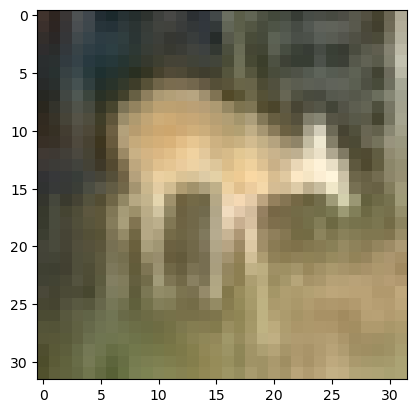

In [42]:
plt.imshow(img)
plt.show()

In [46]:
real = [cv2.imread(imgfile) for imgfile in real_imgfile_list]
fake = [cv2.imread(imgfile) for imgfile in fake_imgfile_list]

In [47]:
# np.float16
real = np.array(real)
fake = np.array(fake)


In [48]:
real.shape

(50000, 32, 32, 3)

In [49]:
fake.shape

(50000, 32, 32, 3)

In [51]:
fake.dtype

dtype('uint8')

In [52]:
real.mean(), real.min(), real.max()

(120.68823526692708, 0, 255)

In [54]:
real = real / 255
fake = fake / 255

In [55]:
real.mean(), real.min(), real.max()

(0.4732871971252034, 0.0, 1.0)

In [15]:
fungi = [
    glob(f'../data/defungi/{h}/*') for h in [
        'H1', 'H2', 'H3', 'H5', 'H6'
    ]
]

In [16]:
[len(h) for h in fungi]

[4404, 2334, 819, 818, 739]

In [17]:
fungi = [
    np.array([cv2.imread(imgfile) for imgfile in h])
    for h in fungi
]

In [18]:
[h.shape for h in fungi]

[(4404, 500, 500, 3),
 (2334, 500, 500, 3),
 (819, 500, 500, 3),
 (818, 500, 500, 3),
 (739, 500, 500, 3)]

In [19]:
fungi = [
    h[:500, :]
    for h in fungi
]

Could use albumentations to augment underrepresented classes, oversampling etc., but use undersampling (correct?) since this already takes 6.5GB as it is...

In [ ]:
fungi = [
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB
]

In [20]:
4404 + 2334 + 819 + 818 + 739

9114

In [21]:
fungi = np.concatenate(fungi)

In [22]:
fungi.shape

(2500, 500, 500, 3)

In [12]:
fungi.shape

(9114, 500, 500, 3)

In [13]:
9114 * 500 * 500 * 3 / 1024**2

6518.840789794922

In [23]:
2500 * 500 * 500 * 3 / 1024**2

1788.1393432617188

In [26]:
fungi_labels = np.zeros(2500)
fungi_labels[500:1000] = 1
fungi_labels[1000:1500] = 2
fungi_labels[1500:2000] = 3
fungi_labels[2000:] = 4

In [27]:
fungi_labels.shape

(2500,)

In [ ]:
cv2.cvt_color

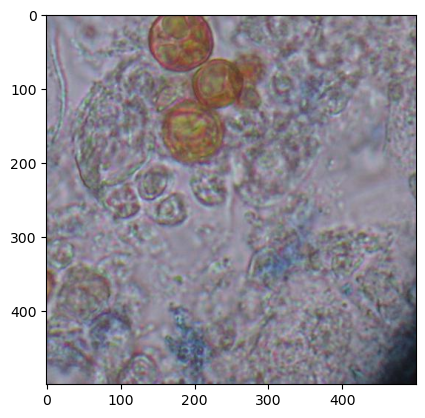

In [41]:
plt.imshow(fungi[1780])